# Κώδικας
Αρχικά κάνουμε εισαγωγή των βιβλιοθηκών που θα χρησιμοποιήσουμε

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
import pandas as pd

Στη συνέχεια εισάγουμε το dataset που θα χρησιμοποιήσουμε ως ένα Pandas DataFrame και το ελέγχουμε συνοπτικά.

In [2]:
data = pd.read_csv(r'C:\Users\user\Desktop\datasets\dokimastika\data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Θα κρατήσουμε ως labels των κατηγοριών μας το χαρακτηριστικό 'diagnosis' και τα features 2-31 θα χρησιμοποιηθούν ως δεδομένα ανάλυσης.

Αρχικά για να έχουμε μια πρώτη εικόνα του δείγματός μας, θα φτιάξουμε ένα pie chart που θα μας δείχνει την κατανομή των κατηγοριών.

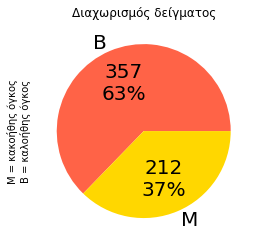

In [4]:
def label_function(val):
    return f'{val / 100 * len(data):.0f}\n{val:.0f}%'

data.groupby('diagnosis').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 20},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.title('Διαχωρισμός δείγματος')
plt.ylabel('Μ = κακοήθης όγκος\nΒ = καλοήθης όγκος')
plt.show()

Παρατηρούμε λοιπόν ότι στο δείγμα μας έχου 37% κακοήθεις όγκους (M = Maligant) και 63% καλοήθεις (B = Benign).

Έπειτα διαχωρίζουμε τα δεδομένα που θα χρησιμοποιήσουμε X (τροποποιώντας τα σε numpy arrays) σε σχέση με τους κατηγοριοποιητές Y και μετασχηματίζουμε τα labels των κατηγοριών τοποθετώντας 1 στα labels των κακοήθων όγκων και 0 στα labels των καλοήθων όγκων.

In [5]:
new_data = data.to_numpy()
X = new_data[:, 3:31]
Y = new_data[:,1]
for i in range(len(Y)):
    if Y[i] == 'M':
        Y[i]=1
    else:
        Y[i] = 0

Y = list(Y)

Στη μελέτη μας η οποία αποσκοπεί στη σύγκριση των διαφόρων μεθόδων επιλογής χαρακτηριστικών, θα χρησιμοποιήσουμε ως classifiers δέντρα αποφάσεων και Naive Bayes. Όσον αφορά τα δέντρα αποφάσεων, για να υπάρχει ποικιλία, θα χρησιμοποιηθεί ο CART αλγόριθμος για τη επαγωγή τους, ενώ ως μέτρα επιλογής χαρακτηριστιών θα χρησιμοποιήσουμε τον δείκτη Gini και την Εντροπία.

Αρχικά θα χρησιμοποιήσουμε τις μεθόδους φίλτρου που περιγράφηκαν παραπάνω, παίρνοντας κάθε φορά τα k καλύτερα χαρακτηριστικά που προέκυψαν με τη βοήθεια των στατιστικών μέτρων που χρησιμοποιήθηκαν.

Κάτι που θα πρέπει να ορίσουμε αρχικά ως μέτρο και αποτελεί κατά κάποιο τρόπο υπερπαράμετρο στο γενικότερο πρόβλημά μας, είναι το ποσοστό train/test set που θα χωρίσουμε το δείγμα μας.
Μια πρώτη σκέψη είναι να το διαχωρίσουμε σε 70/30 %. Αφού η υπολογιστική ισχύς μας το επιτρέπει, θα τρέξουμε όλες τις μεθόδους που θα χρησιμοποιήσουμε σε όλους τους αλγορίθμους, παίρνοντας όλους τους διακριτά καλούς συνδιασμούς.

Παρακάτω είναι ο κώδικας που θα χρησιμοποιηθεί για να μας δώσει μια εικόνα του παραπάνω ζητήματος.

In [6]:
def return_plot(test_size_perc):
  t = [i for i in range(1, 28)]
  Gini_chi2 = []
  Entropy_chi2 = []
  NB_chi2 = []
  Gini_mi = []
  Entropy_mi = []
  NB_mi = []
  Gini_f = []
  Entropy_f = []
  NB_f = []



  for i in range(1, 28):
      X_new = SelectKBest(chi2, k = i).fit_transform(X, Y)
      X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=test_size_perc * .1, random_state=0)

      dtGini = DecisionTreeClassifier(criterion='gini', random_state=0)
      dtEntropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
      NB = GaussianNB()

      dtGini.fit(X_train, Y_train)
      dtEntropy.fit(X_train, Y_train)
      NB.fit(X_train, Y_train)
      
      Gini_score = dtGini.score(X_test, Y_test)
      Entropy_score = dtEntropy.score(X_test, Y_test)
      NB_score = NB.score(X_test, Y_test)

      Gini_chi2.append(Gini_score)
      Entropy_chi2.append(Entropy_score)
      NB_chi2.append(NB_score)
      #----------------------------------------------------------------------------
      X_new = SelectKBest(mutual_info_classif, k = i).fit_transform(X, Y)
      X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=test_size_perc * .1, random_state=0)

      dtGini_new = DecisionTreeClassifier(criterion='gini', random_state=0)
      dtEntropy_new = DecisionTreeClassifier(criterion='entropy', random_state=0)
      NB_new = GaussianNB()

      dtGini_new.fit(X_train, Y_train)
      dtEntropy_new.fit(X_train, Y_train)
      NB_new.fit(X_train, Y_train)
      
      Gini_score_new = dtGini_new.score(X_test, Y_test)
      Entropy_score_new = dtEntropy_new.score(X_test, Y_test)
      NB_score_new = NB_new.score(X_train, Y_train)

      Gini_mi.append(Gini_score_new)
      Entropy_mi.append(Entropy_score_new)
      NB_mi.append(NB_score_new)
      #----------------------------------------------------------------------------
      X_new = SelectKBest(f_classif, k = i).fit_transform(X, Y)
      X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=test_size_perc * .1, random_state=0)

      dtGini_f = DecisionTreeClassifier(criterion='gini', random_state=0)
      dtEntropy_f = DecisionTreeClassifier(criterion='entropy', random_state=0)
      NB_f_model = GaussianNB()

      dtGini_f.fit(X_train, Y_train)
      dtEntropy_f.fit(X_train, Y_train)
      NB_f_model.fit(X_train, Y_train)
      
      Gini_score_f = dtGini_f.score(X_test, Y_test)
      Entropy_score_f = dtEntropy_f.score(X_test, Y_test)
      NB_score_f = NB_f_model.score(X_train, Y_train)

      Gini_f.append(Gini_score_f)
      Entropy_f.append(Entropy_score_f)
      NB_f.append(NB_score_f)

  return t, Gini_chi2, Entropy_chi2, NB_chi2, Gini_mi, Entropy_mi, NB_mi, Gini_f, Entropy_f, NB_f

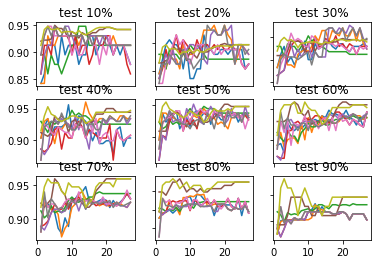

In [7]:
t_per = []

fig, axs = plt.subplots(3, 3)
perce = 1

for i in range(3):
  for j in range(3):
    empty_list = []
    t, Gini_chi2, Entropy_chi2, NB_chi2, Gini_mi, Entropy_mi, NB_mi, Gini_f, Entropy_f, NB_f = return_plot(perce)
    axs[i, j].plot(t, Gini_chi2)
    axs[i, j].plot(t, Entropy_chi2)
    axs[i, j].plot(t, NB_chi2)
    axs[i, j].plot(t, Gini_mi)
    axs[i, j].plot(t, Entropy_mi)
    axs[i, j].plot(t, NB_mi)
    axs[i, j].plot(t, Gini_f)
    axs[i, j].plot(t, Entropy_f)
    axs[i, j].plot(t, NB_f)
    axs[i, j].set_title('test ' + str(perce) +'0%')
    for h in range(len(Gini_chi2)):
        empty_list.append((Gini_chi2[h] + Entropy_chi2[h] + NB_chi2[h] + Gini_mi[h] + Entropy_mi[h] + NB_mi[h] + Gini_f[h] + Entropy_f[h] + NB_f[h])/9)
    t_per.append(empty_list)
    perce+=1
    
for ax in axs.flat:
    ax.label_outer()
    
#Αν θέλουμε να δούμε συγκεκριμένα σε ποια μέθοδο/αλγόριθμο αντιστοιχεί κάθε χρώμμα ενεργοποιούμε την παρακάτω εντολή
#plt.legend(['Gini_chi2', 'Entropy_chi2', 'NB_chi2', 'Gini_mi', 'Entropy_mi', 'NB_mi', 'Gini_f', 'Entropy_f', 'NB_f'])
#και μας βγάζει τις αντίστοιχες ονοματοδοσίες
#εδώ όμως δεν θα το κάνουμε αυτό γιατί στο notebook μας χαλάει την εικόνα
#ενδύκνειτε παρόλαυτά για κάποιους άλλους editors

plt.show()

Τώρα στο παρακάτω κομμάτι κώδικα παίρνουμε το μέσο όρο της ακρίβειας των μεθόδων για κάθε αριθμό πλήθους επιλογής χαρακτηριστικών και κάθε περίπτωση διαχωρισμού train/test set σε ποσοστά επί της εκατό όπως παραπάνω

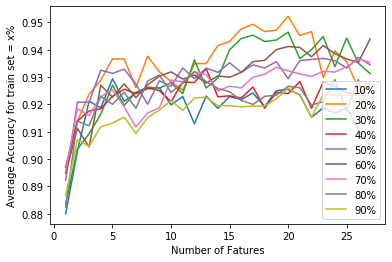

In [9]:
for i in t_per:
    plt.plot(t, i)
plt.xlabel('Number of Fatures')
plt.ylabel('Average Accuracy for train set = x%')
plt.legend(['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%'])
plt.show()

Παρατηρούμε ότι σχεδόν για κάθε περίπτωση τελικής επιλογής πλήθους χαρακτηριστικών, έχουμε μεγαλύτερο accuracy όταν παίρνουμε το test set να αποτελεί το 20 ή 30% του δείγματος. Ως εκ τούτου από εδώ και στο εξής θα επιλέξουμε να κάνουμε τον διαχωρισμό 75/25.

Αυτό που ίσως θα μπορούσε να μας προκαλέσει κάποια εντύπωση, είναι το γεγονός ότι σε κάθε περίπτωση το accuracy κάθε αλγορίθμου δεν πέφτει κάτω απ' το 80%, ανεξάρτητα απ' το διαχωρισμό των train/test sets. Ακόμα δηλαδή κι αν πάρουμε ως train set το 10% του δείγματος, επιλέγοντας μέσω κάποιας μεθόδου επιλογής χαρακτηριστικών 1 ή 2 το πλήθος χαρακτηριστικά, το ποσοστό προβλεπτικής ακριβείας του αλγορίθμου παραμένει αρκετά υψηλό. Αυτό μας λέει με μια πρώτη ματιά ότι οι αλγόριθμοι που χρησιμοποιούμε είναι αρκετά αποδοτικοί.
Από την άλλη μεριά, ενδεχομένως να παίζει ρόλο το γεγονός ότι κάνουμε εν τέλει δυαδική κατηγοριοποίηση. Αν δηλαδή είχεμε περισσότερες κλάσεις, ενδεχομένως το ποσοστό ακριβείας μας να έπεφτε αρκετα. Αυτό μπορεί να ελεγχεί μελλοντικά εξετάζοντας κάποιο άλλο dataset.

Τώρα θα τρέξουμε ξανά όλους τους αλγορίθμους κι με ένα heat map θα βρούμε με ποιον συνδιασμό πετυχαίνουμε το μέγιστο ποσοστό ακριβείας μοντέλου.

In [28]:
methods = ['Gini_chi2', 'Entropy_chi2', 'NB_chi2', 'Gini_mi', 'Entropy_mi', 'NB_mi', 'Gini_f', 'Entropy_f', 'NB_f']
num_of_features = [str(i) for i in range(1, 29)]

heat_map = np.zeros((9, 28))

for i in range(1, 29):
    X_new = SelectKBest(chi2, k = i).fit_transform(X, Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=.25, random_state=0)

    dtGini = DecisionTreeClassifier(criterion='gini', random_state=0)
    dtEntropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
    NB = GaussianNB()

    dtGini.fit(X_train, Y_train)
    dtEntropy.fit(X_train, Y_train)
    NB.fit(X_train, Y_train)
      
    Gini_score = dtGini.score(X_test, Y_test)
    Entropy_score = dtEntropy.score(X_test, Y_test)
    NB_score = NB.score(X_test, Y_test)

    heat_map[0][i-1] = Gini_score
    heat_map[1][i-1] = Entropy_score
    heat_map[2][i-1] = NB_score
    #----------------------------------------------------------------------------
    X_new = SelectKBest(mutual_info_classif, k = i).fit_transform(X, Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=.25, random_state=0)

    dtGini_new = DecisionTreeClassifier(criterion='gini', random_state=0)
    dtEntropy_new = DecisionTreeClassifier(criterion='entropy', random_state=0)
    NB_new = GaussianNB()

    dtGini_new.fit(X_train, Y_train)
    dtEntropy_new.fit(X_train, Y_train)
    NB_new.fit(X_train, Y_train)
      
    Gini_score_new = dtGini_new.score(X_test, Y_test)
    Entropy_score_new = dtEntropy_new.score(X_test, Y_test)
    NB_score_new = NB_new.score(X_train, Y_train)

    heat_map[3][i-1] = Gini_score_new
    heat_map[4][i-1] = Entropy_score_new
    heat_map[5][i-1] = NB_score_new
    #----------------------------------------------------------------------------
    X_new = SelectKBest(f_classif, k = i).fit_transform(X, Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=.25, random_state=0)

    dtGini_f = DecisionTreeClassifier(criterion='gini', random_state=0)
    dtEntropy_f = DecisionTreeClassifier(criterion='entropy', random_state=0)
    NB_f_model = GaussianNB()

    dtGini_f.fit(X_train, Y_train)
    dtEntropy_f.fit(X_train, Y_train)
    NB_f_model.fit(X_train, Y_train)
      
    Gini_score_f = dtGini_f.score(X_test, Y_test)
    Entropy_score_f = dtEntropy_f.score(X_test, Y_test)
    NB_score_f = NB_f_model.score(X_train, Y_train)

    heat_map[6][i-1] = Gini_score_f
    heat_map[7][i-1] = Entropy_score_f
    heat_map[8][i-1] = NB_score_f

In [30]:
for i in range(len(heat_map)):
    for j in range(len(heat_map[i])):
        heat_map[i][j] = round(heat_map[i][j], 2)

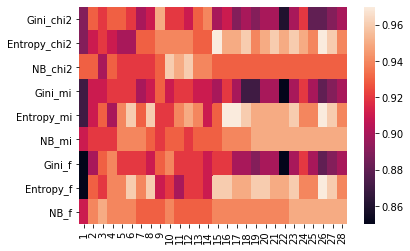

In [32]:
import seaborn as sns
ax = sns.heatmap(heat_map, xticklabels=num_of_features, yticklabels=methods)

Τέλος δίνουμε παρακάτω μια συνεχή προσέγγιση της κατανομής του accuracy rate για κάθε περίπτωση και στοιχεία της κατανομής τους, όπως η διασπορά των τιμών και ο μέσος όρος.

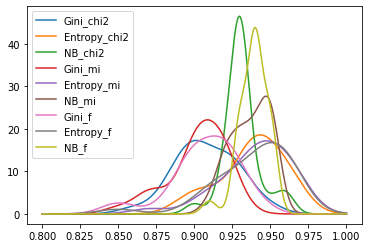

In [48]:
from scipy import stats

density_0 = stats.kde.gaussian_kde(heat_map[0])
density_1 = stats.kde.gaussian_kde(heat_map[1])
density_2 = stats.kde.gaussian_kde(heat_map[2])
density_3 = stats.kde.gaussian_kde(heat_map[3])
density_4 = stats.kde.gaussian_kde(heat_map[4])
density_5 = stats.kde.gaussian_kde(heat_map[5])
density_6 = stats.kde.gaussian_kde(heat_map[6])
density_7 = stats.kde.gaussian_kde(heat_map[7])
density_8 = stats.kde.gaussian_kde(heat_map[8])
t = np.linspace(.8, 1., 1000)
plt.plot(t, density_0(t))
plt.plot(t, density_1(t))
plt.plot(t, density_2(t))
plt.plot(t, density_3(t))
plt.plot(t, density_4(t))
plt.plot(t, density_5(t))
plt.plot(t, density_6(t))
plt.plot(t, density_7(t))
plt.plot(t, density_8(t))

plt.legend(methods)
plt.show()

In [49]:
for i in range(len(heat_map)):
    print(methods[i], ': Var =', np.var(heat_map[i]), ', Mean =', np.mean(heat_map[i]) )

Gini_chi2 : Var = 0.00039540816326530626 , Mean = 0.9078571428571429
Entropy_chi2 : Var = 0.00043112244897959085 , Mean = 0.937857142857143
NB_chi2 : Var = 0.00013099489795918317 , Mean = 0.9310714285714285
Gini_mi : Var = 0.0003525510204081639 , Mean = 0.902142857142857
Entropy_mi : Var = 0.0005214285714285704 , Mean = 0.9400000000000001
NB_mi : Var = 0.00015038265306122355 , Mean = 0.9367857142857142
Gini_f : Var = 0.00046326530612244936 , Mean = 0.9071428571428569
Entropy_f : Var = 0.0006289540816326518 , Mean = 0.9382142857142858
NB_f : Var = 8.099489795918309e-05 , Mean = 0.9389285714285714


Παρατηρούμε ίσως ο καλύτερος συνδιασμός είναι decision tree χρησιμοποιώντας την εντροπία, όπου χρησιμοποιώντας χ2-test, μπορούμε να πετύχουμε εξαιρετικό ποσοστό ακριβείας πρόβληεψης χρησιμοποιώντας 15 χαρακτηριστικά.

Γενικότερα παρατηρούμε ότι decision trees χρησιμοποιώντας δείκτη Gini παρουσιάζουν καλύτερο ποσοστό ακριβείας πρόβλεψης όσο μικρότερο είναι το πλήθος των χαρακτηριστικών που επιλέγουμε να χρησιμοποιήσουμε, αν και γενικότερα φαίνεται να είναι σε κάθε περίπτωση χειρότερο σε σχέση με τους άλλους δύο αλγορίθμους.

Decision trees χρησιμοποιώντας εντροπία φαίνονται να λειτουργούν αρκετά καλύτερα χρησιμοποιώντας περισσότερα χαρακτηριστικά ανεξαρτήτου της μεθόδου επιλογής που χρησιμοποιούμε, ενώ ο Naive Bayes φαίνεται να έχει σταθερή απόδοση σε γενικές γραμμές (αυτό γίνεται πολύ γρήγορα κατανοητό βλέποντας ότι το accuracy του έχει σταθερά πολύ μικρή διασπορά).

Τώρα θα περάσουμε σε εφαρμογή ενσωματωμένων μεθόδων και πιο συγκεκριμένα στη LASSO και στη Ridge Regression.

Εδώ θα πρέπει να κάνουμε και tuning στις υπερπαραμέτρους της κάθε μεθόδου.